# ***FakeMind-ML4VA Project: Detecting Droughts in Virginia***

Team FakeMind is composed of three UVA students: Alex Fetea, Kamil Urbanowski, and Tyler Kim. FakeMind's goal is to predict droughts in Virginia using a dataset found online. This will help farmers take better care of their farms by taking preparing ahead of time for possible droughts.

The link to the datasets can be found below:

https://resilience.climate.gov/datasets/esri2::us-drought-by-state/explore

https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily


In general, this notebook will store our code for the ML4VA project. This notebook will also be divided into 8 Steps:

1. Big Picture & Setup
2. Getting the Data
3. Discovering and Visualizing the Data
4. Data Cleaning
5. Selecting and Training the Models
6. Fine Tuning the Model
7. Presentation
8. Launch


## **1-Big Picture & Setup**

In [1]:
# import the necessary libraries
import sklearn
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

np.random.seed(17)

## **2-Getting the Data**

In [14]:
# loads the data and includes some information and statistics about the dataset
def load_data(filepath):
  data = pd.read_csv(filepath)

  file_size = 7.1
  num_entries = 62313
  num_features = 15
  num_categorical = 2
  missing_value_exists = True

  # print the output
  print("File Size:", str(file_size) + "+ MB")
  print("Number of Entries:", str(num_entries))
  print("Number of Features:", str(num_features))
  print("Do Categorical variables exist:", "Yes" if num_categorical > 0 else "No", "(" + str(num_categorical) + ")")
  print("Do missing values exist:", "Yes" if missing_value_exists else "No")
  print("\n")

  print(data.info())
  print(data.describe())

  return data

In [15]:
# loads the data
drought_data = load_data("./USA_Drought_Intensity_2000_-_Present.csv")

File Size: 7.1+ MB
Number of Entries: 62313
Number of Features: 15
Do Categorical variables exist: Yes (2)
Do missing values exist: Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62313 entries, 0 to 62312
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID    62313 non-null  int64  
 1   period      62313 non-null  int64  
 2   state_abbr  62313 non-null  object 
 3   admin_fips  62313 non-null  int64  
 4   ddate       62313 non-null  object 
 5   nothing     62272 non-null  float64
 6   d0          62270 non-null  float64
 7   d1          62292 non-null  float64
 8   d2          62299 non-null  float64
 9   d3          62302 non-null  float64
 10  d4          62309 non-null  float64
 11  D0_D4       62272 non-null  float64
 12  D1_D4       62294 non-null  float64
 13  D2_D4       62300 non-null  float64
 14  D3_D4       62302 non-null  float64
dtypes: float64(10), int64(3), object(2)
memory usage: 7

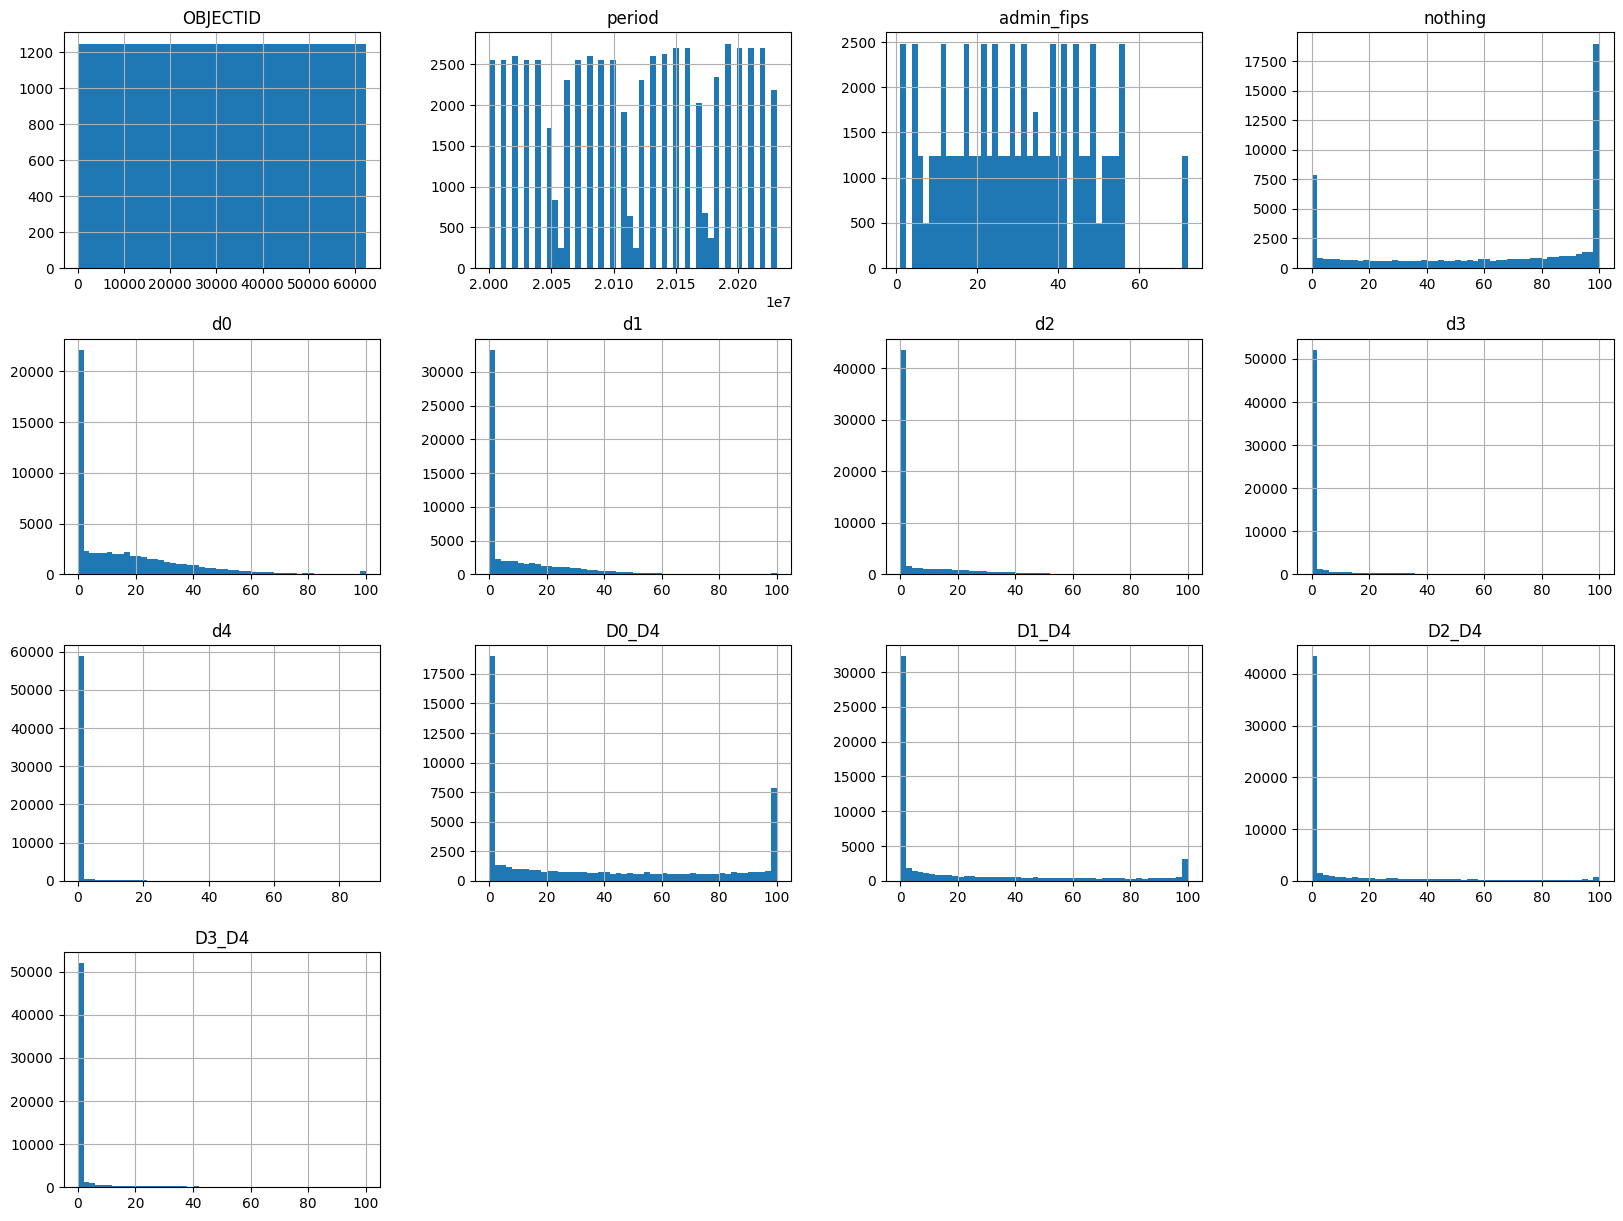

In [16]:
%matplotlib inline
drought_data.hist(bins = 50, figsize = (20, 15))
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(drought_data, test_size = 0.2, random_state = 17)

In [19]:
print(train_set.shape)
print(test_set.shape)

(49850, 15)
(12463, 15)


## **3-Discovering and Visualizing the Data**

## **4-Data Cleaning**

## **5-Selecting and Training the Models**

## **6-Fine Tuning the Model**

## **7-Presentation**

## **8-Launch**